# HW2 - Q3: Evaluating Robustness of Neural Networks (35 points)

**Keywords**: Adversarial Robustness, FGSM/PGD Attack, Certification

**About the dataset**: \
The [MNIST](https://en.wikipedia.org/wiki/MNIST_database) database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems.\
The MNIST database contains 70,000 labeled images. Each datapoint is a $28\times 28$ pixels grayscale image.\
Here we will be starting off with a pre-trained 2-hidden-layer model on the full MNIST dataset.

**Agenda**:
* In this programming challenge, you will implement adversarial attack on an MNIST neural network model as well as visualize those attacks. 
* You will do this by solving the inner maximization problem using FGSM (Fast Gradient Sign Method) and PGD (Projected Gradient Descent).
* You will then perform verification of the model using Interval-Bound -Propagation (IBP).


**Note:**
* It is important that you use **GPU accelaration** for this Question.
* A note on working with GPU:
  * Take care that whenever declaring new tensors, set `device=device` in parameters. 
  * You can also move a declared torch tensor/model to device using `.to(device)`. 
  * To move a torch model/tensor to cpu, use `.to('cpu')`
  * Keep in mind that all the tensors/model involved in a computation have to be on the same device (CPU/GPU).
* Run all the cells in order.
* **Do not edit** the cells marked with !!DO NOT EDIT!!
* Only **add your code** to cells marked with !!!! YOUR CODE HERE !!!!
* Do not change variable names, and use the names which are suggested.



---



### Preprocessing

In [1]:
# install this library
!pip install gdown

* We will be using a pre-trained 2-hidden layer neural network model (`nn_model`) that takes as input features vectors of size 784, and ouputs logits vector of size 10. Each of the two hidden layers are of size 1024.

* This is a highly accurate model with train accuracy of approx 99.88% and test accuracy of approx 98.14%.

* We will also be loading and initializing a dummy model (`test_model`) for unit testing code implementation.

In [2]:
# !!DO NOT EDIT!!
# imports 
import torch
import torch.nn as nn
import numpy as np
import requests
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import gdown
from zipfile import ZipFile

# set hardware device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# loading the dataset full MNIST dataset
mnist_train = datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())

mnist_train.data = mnist_train.data.to(device)
mnist_test.data = mnist_test.data.to(device)

mnist_train.targets = mnist_train.targets.to(device)
mnist_test.targets = mnist_test.targets.to(device)

# number of target classes
num_classes = 10
num_classes_test = 2 

# reshape and min-max scale
X_train =  (mnist_train.data.reshape((mnist_train.data.shape[0], -1))/255).to(device)
y_train = mnist_train.targets
X_test = (mnist_test.data.reshape((mnist_test.data.shape[0], -1))/255).to(device)
y_test = mnist_test.targets


# load pretrained and dummy model
url_nn_model = 'https://bit.ly/3sKvyOs'
url_models   = 'https://bit.ly/3lsVcDn'
gdown.download(url_nn_model, 'nn_model.pt')
gdown.download(url_models, 'models.zip')
ZipFile("models.zip").extractall("./")

from model import NN_Model
from test_model import Test_Model
nn_model = torch.load("./nn_model.pt").to(device)
print('Pretrained model (nn_model):', nn_model)

test_model = Test_Model()
print('Dummy model (test_model):', test_model)

Downloading...
From: https://bit.ly/3sKvyOs
To: C:\Users\Huining\nn_model.pt
100%|█████████████████████████████████████████████████████████████████████████████| 7.46M/7.46M [00:00<00:00, 8.97MB/s]
Downloading...
From: https://bit.ly/3lsVcDn
To: C:\Users\Huining\models.zip
100%|█████████████████████████████████████████████████████████████████████████████████████| 1.55k/1.55k [00:00<?, ?B/s]

Pretrained model (nn_model): NN_Model(
  (l1): Linear(in_features=784, out_features=1024, bias=True)
  (l2): Linear(in_features=1024, out_features=1024, bias=True)
  (l3): Linear(in_features=1024, out_features=10, bias=True)
)
Dummy model (test_model): Test_Model(
  (l1): Linear(in_features=2, out_features=3, bias=True)
  (l2): Linear(in_features=3, out_features=3, bias=True)
  (l3): Linear(in_features=3, out_features=2, bias=True)
)


In this problem set you need to access the individual layers of the neural network. The below piece of code creates a list of ordered layers for each of the neural network models for easy access.

In [3]:
# This will save the linear layers of the neural network model in a ordered list
# Eg:
# to access weight of first layer: model_layers[0].weight
# to access bias of first layer: model_layers[0].bias
model_layers = [layer for layer in nn_model.children()] # for nn_model
test_model_layers = [layer for layer in test_model.children()] # for dummy model

In [4]:
# !!DO NOT EDIT!!
# utility function to plot the images
def plot_images(X,y,yp,M,N):
  f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
  for i in range(M):
    for j in range(N):
      ax[i][j].imshow(1-X[i*N+j].cpu().numpy(), cmap="gray")
      title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
      plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
      ax[i][j].set_axis_off()
    plt.tight_layout()

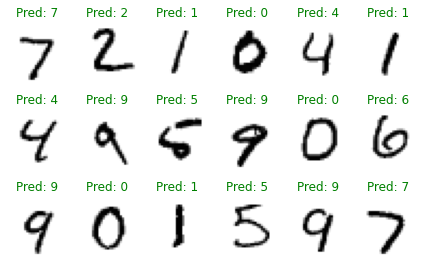

In [11]:
# !!DO NOT EDIT!!
# let us visualize a few test examples
example_data = mnist_test.data[:18]/255
example_data_flattened  = example_data.view((example_data.shape[0], -1)).to(device) # needed for training
example_labels = mnist_test.targets[:18].to(device)
plot_images(example_data, example_labels, nn_model(example_data_flattened), 3, 6)



---



---




### **(a) FGSM attack:**  In this part you will create a few adversarial examples using FGSM attack. Use an attack budget $\epsilon=0.05$.  (5 points)
In the Fast Gradient Sign Method (FGSM), the perturbation $\delta$ on an input example (e.g. input image) $X$ is given by $\epsilon\cdot sign(g)$, where $g$ is the gradient of the loss function $g:=∇_\delta \ell(h_θ (x+δ),y)$, and $ℓ$ is the loss function, more precisely `nn.CrossEntropyLoss`. In the first timestep, this value of $\delta$ is $0$.

### **#1.** Define a function `fgsm` which takes as input the neural network model (`model`), test examples (`X`), target labels (`y`), and the attack budget (`epsilon`). Return the value of the perturbation ($\delta$) after one gradient descent step.

In [6]:
#######
# !!! YOUR CODE HERE !!!

def fgsm(model, X, y, epsilon):
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

#######

### **#2.** Now, consider the first few examples from the training dataset which are already defined above as `example_data_flattened` and `example_labels`. Using the function `fgsm`, get the value of `delta` for these examples. Perform prediction on the modified dataset (`example_data_flattened + delta`), and construct a similar plot of images as above. You may reuse the `plot_images` function. Is the attack successful?

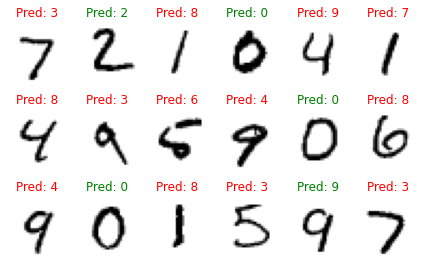

In [14]:
#######
# !!! YOUR CODE HERE !!!

delta = fgsm(nn_model, example_data_flattened, example_labels, 0.05)
yp = nn_model(example_data_flattened + delta)
plot_images(example_data, example_labels, yp, 3, 6)

#######

We can see that the attack was not successful, we had much more incorrect predictions.
$$
\\
$$



---



### **(b) PGD attack:**  In this part you will create a few adversarial examples using PGD attack. Use an attack budget $\epsilon=0.05$.  (10 points)

**Note:** For the Projected Gradient Descent (PGD) attack, you create an adversarial example by iteratively performing gradient descent with a fixed step size $\alpha$. The update rule is: $δ:=P(δ+α∇_δ ℓ(h_θ(x+δ),y))$, where $δ$ is the perturbation, $θ$ are the frozen DNN parameters, $x$ and $y$ is the training example and its ground truth label respectively, $h_θ$ is the hypothesis function, $ℓ$ denotes the loss function, and $P$ denotes the projection onto a norm ball ($l_\infty, l_1, l_2$, etc.) of interest. For $l_\infty$ ball, this just means clamping the value of $\delta$ between $-\epsilon$ and $\epsilon$.

### **#1.** Instead of using FGSM, now use Projected Gradient Descent (PGD) with projection on $l_\infty$ ball for the attack. Define a function `pgd` that takes as input the neural network model (`model`), training examples (`X`), target labels (`y`), step size (`alpha`), attack budget (`epsilon`), and number of iterations (`num_iter`). Return the perturbation ($\delta$) after `num_iter` gradient descent steps. 

In [15]:
#######
# !!! YOUR CODE HERE !!!

def pgd(model, X, y, epsilon, alpha, num_iter):
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + X.shape[0]*alpha*delta.grad.data).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

#######

### **#2.** Now use the PGD attack for the examples from `example_data_flattened`. Use `alpha=1000`, `num_iter=1000`, and create a similar plot as before. Is the attack successful?

### The value of `alpha` is large because the neural network model is pretrained and is therefore at the local minima. The value of gradients here is extremely small, and we therefore need a huge value of step size to have any hope of moving out of the local minima.

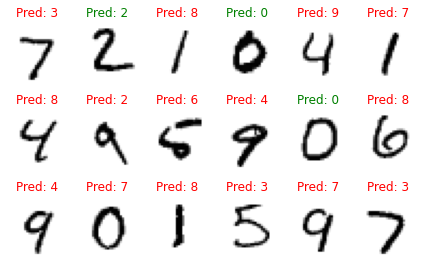

In [16]:
#######
# !!! YOUR CODE HERE !!!

delta = pgd(nn_model, example_data_flattened, example_labels, 0.05, 1000, 1000)
yp = nn_model(example_data_flattened + delta)
plot_images(example_data, example_labels, yp, 3, 6)

#######

This attack does not seem successful either.
$$
\\
$$



---



### **(c)**  Use FGSM and PGD to create adversarial examples using the complete test dataset. Create the datasets with different values of `epsilon: [0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2]`. For each of the dataset created with different `epsilon` values and attack type, get the model accuracies. Plot a (single) graph of accuracy vs. epsilon for both attack types. Note that `epsilon=0` means no attack, so you can just get accuracy on the original dataset. (10 points)

#### <font color="red">It is important that you use **GPU accelaration** for this part.</font>


In [ ]:
#######
# !!! YOUR CODE HERE !!!



#######



---



### **(d)** Use the Interval-Bound-Propagation (IBP) technique to certify robustness of the model through lower bound with a given value of epsilon. (10 points)

* In this section, you will find the lower and upper bounds for each neuron of each of the linear layers of the neural network model.

* Note that the initial bound is the bound of the first layer, which is the input example. For the $l_\infty$ perturbation, the initial lower bound is simply $max(0, x-\epsilon)$, and the  initial upper bound is $min(1, x+\epsilon)$, for an input example $x$ (Note that each value of $x$ must lie in between 0 and 1, thats why the $min$ and $max$).

* In the function, propagate the initial bound across all layers of the neural network and return a list of tuples of *pre-activation* lower and upper bound for each layer. The *pre-activation* bounds are the bound before applying ReLU activation. 

* Let's review a bit of the IBP bounds: let $z=Wx+b$ denote an intermediate linear layer of the model, and suppose $\hat{l} \le x \le \hat{u}, l \le z \le u$, we have:\
$l=W_+\hat{l}+W_-\hat{u}+b$\
$u=W_+\hat{u}+W_-\hat{l}+b$\
Note $l, u$ here are the *pre-activation* bounds

* If a non-linear ReLU activation function $\sigma(\cdot)$ is applied to the layer $z=Wx+b$, then the bounds of $\sigma(z)$ will be: $l=\sigma(\hat{l}), u = \sigma(\hat{u})$ as $\sigma$ is a monotonically non-decreasing function. I.e. $l \leq \sigma(z) \leq u$. The $l,u$ here are the *post-activation* bounds. Note, here we use $\hat{l}$ and $\hat{u}$ to denote the bounds of the previous layer: $\hat{l} \leq z \leq \hat{u}$. 

### **#1.** Define a function `bound_propagation` which takes as input an ordered list of layers of the model (`model_layers`), a feature vector (`x`), and attack budget (`epsilon`). Return a list of tuples of `pre-activation` lower and upper bound tensors for each layer. Verify that your implementation is correct by verifying the results of your function on the unit tests given below.

In [ ]:
#######
# !!! YOUR CODE HERE !!!

#######

In [ ]:
# !!DO NOT EDIT!!
sample_epsilon = 0.2
# unit test - 1
x_1 = torch.tensor([[0.1, 0.9]], device=device)
test_bounds_1 = bound_propagation(test_model_layers, x_1, sample_epsilon)
assert torch.all(torch.eq(torch.round(test_bounds_1[0][0], decimals=2), torch.tensor([[0.0000, 0.7000]], device=device)))
assert torch.all(torch.eq(torch.round(test_bounds_1[0][1], decimals=2), torch.tensor([[0.3000, 1.0000]], device=device)))
assert torch.all(torch.eq(torch.round(test_bounds_1[1][0], decimals=2), torch.tensor([[0.0000, 1.4000, 1.2000]], device=device)))
assert torch.all(torch.eq(torch.round(test_bounds_1[1][1], decimals=2), torch.tensor([[0.4500, 2.6000, 1.5000]], device=device)))
assert torch.all(torch.eq(torch.round(test_bounds_1[2][0], decimals=2), torch.tensor([[ 2.6500, -0.8000,  2.1000]], device=device)))
assert torch.all(torch.eq(torch.round(test_bounds_1[2][1], decimals=2), torch.tensor([[6.7000, 0.1000, 4.3500]], device=device)))

# unit test - 2
x_1 = torch.tensor([[0.4, 0.5]], device=device)
test_bounds_2 = bound_propagation(test_model_layers, x_1, sample_epsilon)
assert torch.all(torch.eq(torch.round(test_bounds_2[0][0], decimals=2), torch.tensor([[0.2000, 0.3000]], device=device)))
assert torch.all(torch.eq(torch.round(test_bounds_2[0][1], decimals=2), torch.tensor([[0.6000, 0.7000]], device=device)))
assert torch.all(torch.eq(torch.round(test_bounds_2[1][0], decimals=2), torch.tensor([[0.4000, 1.0000, 0.8000]], device=device)))
assert torch.all(torch.eq(torch.round(test_bounds_2[1][1], decimals=2), torch.tensor([[1.0000, 2.6000, 1.2000]], device=device)))
assert torch.all(torch.eq(torch.round(test_bounds_2[2][0], decimals=2), torch.tensor([[-0.2000, -0.7000,  0.4000]], device=device)))
assert torch.all(torch.eq(torch.round(test_bounds_2[2][1], decimals=2), torch.tensor([[5.2000, 0.5000, 3.4000]], device=device)))

### **#2.** Let the lower and upper bounds of the final layer of the model be $l^{final}$ and $u^{final}$ respectively. Then we say that an input example $x$ has a robutness certificate $\epsilon$ if the criteria: $l^{final}[c]-u^{final}[i]>0, \forall i\ne c$, where $c$ denotes the ground truth class of the input $x$. 

* We need to determine the maximum value of epsilon for certified robustness against an adversarial attack for a given example. We can do the same using binary search over a few values of epsilon.

* Define a function `binary_search` that takes as input a sorted array of epsilon values (`epsilons`), an ordered list of neural network model layers (`model_layers`), examples (`X`), corresponding targets (`y`), the number of target classes (`num_classes`). It should return `certified_epsilons` which is a python list of the final values of epsilon certification for each example in input. You can use `None` when unable to find an epsilon value from epsilons. 

* Verify that your implementation is correct by verifying the results of your function on the unit tests given below.

In [ ]:
#######
# !!! YOUR CODE HERE !!!

#######

In [ ]:
# !!DO NOT EDIT!!
epsilons = [x/10000 for x in range(1, 10000)]
# unit test - 1 
sample_X = torch.tensor([[0.1, 0.9], [0.4, 0.5]], device=device)
sample_y = torch.tensor([0,0], device=device)
test_epsilons = binary_search(epsilons, test_model_layers, sample_X, sample_y, num_classes_test)
assert test_epsilons==[0.0028, 0.0067]

### **#3.** Report the certified values of epsilon on the first few examples (simply run the below cell).

In [ ]:
# !!DO NOT EDIT!!
# finding epsilon for first few examples of MNIST dataset using IBP
epsilons = [x/10000 for x in range(1, 10000)]
X = example_data_flattened[0:2]
y = example_labels[0:2]
binary_search(epsilons, model_layers, X, y, num_classes)

---

---

